In [5]:
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np

In [6]:
headers = {'flips_and_switches':['sample_id','num_switches','num_flips','num_correct','switch_error_rate','flip_error_rate','accurately_phased_rate'],
           'switch_errors':['sample_id', 'n_switch_errors',  'num_checked', 'switch_error_rate'],
           'frequency':['minor_allele_count', 'n_switch_errors', 'n_checked', 'switch_error_rate'],
           'type': ['ref_or_alt_allele', 'n_switch_errors', 'n_checked', 'switch_error_rate'],
           'variant_switch': ['variant_id', 'position', 'n_switch_errors', 'n_checked', 'switch_error_rate'],
           'block_length':['sample','switch_error_site']}
stat_prefixes={'flips_and_switches':'flipsAndSwitches',
               'switch_errors':'sample.switch',
               'frequency':'frequency',
               'type':'type',
               'variant_switch':'variant.switch',
               'block_length':'block.switch'}
analysis_suffixes = {'common_variants':{'HPRC_samples':{'phased_with_reference_panel':'common_pangenome_panelphased_vs_pangenome'},
                                        'trios': {'phased_without_parents_or_pedigree':'common_noparents_vs_trios'}},
                     'rare_variants':  {'HPRC_samples':{'phased_with_reference_panel':'rare_pangenome_panelphased_vs_pangenome',
                                                        'phased_without_parents_or_pedigree':'noparents_vs_HPRC',
                                                        'phased_with_parents_and_pedigree':'phased_vs_HPRC'},
                                        'trios': {'phased_without_parents_or_pedigree':'rare_noparents_vs_trios',
                                                        'phased_with_parents_and_pedigree': 'panel_vs_trios'}}}

In [7]:
phasing_stats_datasets = dict()
phasing_stats_folder='/mnt/data/lalli/nf_stage/phasing_T2T/phasing_stats/'
for statistic, header in headers.items():
    phasing_stats_datasets[statistic] = list()
    for variant_category in analysis_suffixes.keys():
        for verification_sample in analysis_suffixes[variant_category].keys():
            for phasing_method, prefix in analysis_suffixes[variant_category][verification_sample].items():
                    for i in list(range(1,23)) + ['X']:
                        file = glob.glob(phasing_stats_folder + f'{prefix}_chr{i}.*{stat_prefixes[statistic]}*')
                        if len(file) == 1:
                            contig_file = pd.read_csv(file[0], sep=' ', names=header)
                            contig_file['chrom'] = f'chr{i}'
                            contig_file['stat'] = statistic
                            contig_file['method_of_phasing'] = phasing_method
                            contig_file['ground_truth_data_source'] = verification_sample
                            contig_file['variants'] = variant_category
                            phasing_stats_datasets[statistic].append(contig_file)
                        else:
                            print (phasing_stats_folder + f'{prefix}_chr{i}.*{stat_prefixes[statistic]}*')
    if len(phasing_stats_datasets[statistic]) > 1:
        phasing_stats_datasets[statistic] = pd.concat(phasing_stats_datasets[statistic]).reset_index(drop=True)

In [8]:
if True: #if flips_and_switches
    HPRC_all_contig_switch_errors = phasing_stats_datasets['flips_and_switches'].groupby(['sample_id','method_of_phasing','ground_truth_data_source','variants']).sum()
    HPRC_all_contig_switch_errors['total_sites'] = HPRC_all_contig_switch_errors.sum(1)
    HPRC_all_contig_switch_errors['switch_error_rate'] = HPRC_all_contig_switch_errors.num_switches/HPRC_all_contig_switch_errors.total_sites*100
    HPRC_all_contig_switch_errors['flip_error_rate'] = HPRC_all_contig_switch_errors.num_flips/HPRC_all_contig_switch_errors.total_sites*100
    HPRC_all_contig_switch_errors['accurately_phased_rate'] = HPRC_all_contig_switch_errors.num_correct/HPRC_all_contig_switch_errors.total_sites*100
    HPRC_all_contig_switch_errors = HPRC_all_contig_switch_errors.loc[HPRC_all_contig_switch_errors.total_sites>0]

/tmp/ipykernel_1831946/3989711371.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  HPRC_all_contig_switch_errors = phasing_stats_datasets['flips_and_switches'].groupby(['sample_id','method_of_phasing','ground_truth_data_source','variants']).sum()


In [9]:
# avg correct block size is this many heterozygous sites:
HPRC_all_contig_switch_errors

num_switches  \
sample_id method_of_phasing                  ground_truth_data_source variants                        
HG00403   phased_with_parents_and_pedigree   trios                    rare_variants            1110   
HG00404   phased_with_parents_and_pedigree   trios                    rare_variants            1088   
HG00405   phased_with_parents_and_pedigree   trios                    rare_variants              12   
          phased_without_parents_or_pedigree trios                    common_variants         22182   
                                                                      rare_variants           29822   
...                                                                                             ...   
NA20358   phased_without_parents_or_pedigree trios                    rare_variants           20553   
NA20359   phased_with_parents_and_pedigree   trios                    rare_variants            1981   
NA20362   phased_with_parents_and_pedigree   trios                    rare_variants               0   
          phased_without_parents_or_pedigree trios                    common_variants         15798   
                                                                      rare_variants           13801   

                                                                                       num_flips  \
sample_id method_of_phasing                  ground_truth_data_source variants                     
HG00403   phased_with_parents_and_pedigree   trios                    rare_variants          420   
HG00404   phased_with_parents_and_pedigree   trios                    rare_variants          413   
HG00405   phased_with_parents_and_pedigree   trios                    rare_variants            4   
          phased_without_parents_or_pedigree trios                    common_variants       5864   
                                                                      rare_variants        11453   
...                                                                                          ...   
NA20358   phased_without_parents_or_pedigree trios                    rare_variants         8501   
NA20359   phased_with_parents_and_pedigree   trios                    rare_variants          741   
NA20362   phased_with_parents_and_pedigree   trios                    rare_variants            0   
          phased_without_parents_or_pedigree trios                    common_variants       5499   
                                                                      rare_variants         5206   

                                                                                       num_correct  \
sample_id method_of_phasing                  ground_truth_data_source variants                       
HG00403   phased_with_parents_and_pedigree   trios                    rare_variants        1487233   
HG00404   phased_with_parents_and_pedigree   trios                    rare_variants        1507807   
HG00405   phased_with_parents_and_pedigree   trios                    rare_variants        1519869   
          phased_without_parents_or_pedigree trios                    common_variants      1774338   
                                                                      rare_variants        1478610   
...                                                                                            ...   
NA20358   phased_without_parents_or_pedigree trios                    rare_variants        2148632   
NA20359   phased_with_parents_and_pedigree   trios                    rare_variants        1293789   
NA20362   phased_with_parents_and_pedigree   trios                    rare_variants        1289272   
          phased_without_parents_or_pedigree trios                    common_variants      1514395   
                                                                      rare_variants        1270265   

                                                                                       switch_error_rate  \
sample_id m

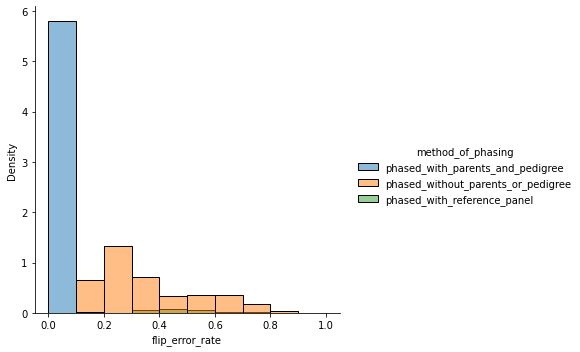

In [10]:
sns.displot(x='flip_error_rate', binwidth=.1, hue='method_of_phasing', data=HPRC_all_contig_switch_errors, stat='density')

In [151]:
def summarize_flips_and_switches(df):
    pass

def summarize_switch_errors(df):
    pass

def summarize_frequency(df):
    pass

def summarize_type(df):
    pass

def summarize_variant_switch(df):
    pass

def summarize_block_length(df):
    # df.block_length = 
    return df
def calc_block_lengths(df):
    return df.groupby(['chrom','sample']).apply(lambda x: x.switch_error_site.diff()).reset_index().switch_error_site

In [117]:
phasing_stats_datasets['block_length']['block_length'] = np.nan
df = phasing_stats_datasets['block_length'].loc[((phasing_stats_datasets['block_length'].method_of_phasing=='phased_with_reference_panel')
                                           & (phasing_stats_datasets['block_length'].ground_truth_data_source=='HPRC_samples')
                                           & (phasing_stats_datasets['block_length'].variants=='common_variants'))]

# for chrom in df.chrom.unique():
#     for sample in df['sample'].unique():
#         df.block_length = df.loc[(df.chrom==chrom) & (df['sample']==sample)].switch_error_site.diff()

In [118]:
x = df.groupby(['chrom','sample']).apply(lambda x: x.switch_error_site.diff())

In [157]:
result = list()
for (method_of_phasing, ground_truth_data_source, variant_category, chrom, sample), df in phasing_stats_datasets['block_length'].groupby(['method_of_phasing','ground_truth_data_source','variants', 'chrom','sample']):
    print(method_of_phasing, ground_truth_data_source, variant_category, chrom, sample)
    print (df.head())
    # df['block_lengths'] = df.apply(lambda x: calc_block_lengths(x))
    # result.append(df)

In [120]:
phasing_stats_datasets['block_length']['block_length'] = 

/tmp/ipykernel_1831946/2988447585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.block_length = df.groupby(['chrom','sample']).apply(lambda x: x.switch_error_site.diff()).reset_index().switch_error_site


0.0

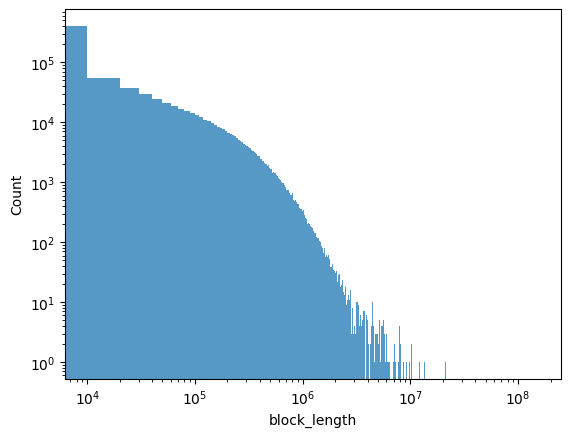

In [121]:
ax = sns.histplot(df.block_length, binwidth=10000)
ax.set_yscale('log')
ax.set_xscale('log')
df.block_length.min()

In [148]:
def plot_phasing_blocks(sample, df, cytobands='chm13v2.0_cytobands_allchrs.bed'):
    """Plot phasing blocks from one sample"""
    from ideograms import plot_ideogram

    data = df.loc[df['sample']==sample, ['chrom', 'switch_error_site']].rename(columns={'switch_error_site':'start'}).reset_index(drop=True)
    # data = data.groupby('chrom').apply(lambda x: x.shift(1)).fillna(0)
    data['end'] = data.groupby('chrom')['start'].shift(-1)
    data = data.dropna()
    data.end = data.end.astype(int)
    data['name'] = data.index.astype(int)
    print(data)
    ax = plot_ideogram('chm13v2.0_cytobands_allchrs.bed', data, figsize=(8,12), data_height=1.2, inclusive=True)
    return ax

      chrom   start        end   name
0      chr1  139203     514232      0
1      chr1  514232     518535      1
2      chr1  518535     598723      2
3      chr1  598723     600001      3
4      chr1  600001     748864      4
...     ...     ...        ...    ...
25677  chrX  920535     921456  25677
25678  chrX  921456     946219  25678
25679  chrX  946219     979711  25679
25680  chrX  979711     981357  25680
25681  chrX  981357  154237271  25681

[25660 rows x 4 columns]
adding ideograms...
adding genes...


<AxesSubplot:>

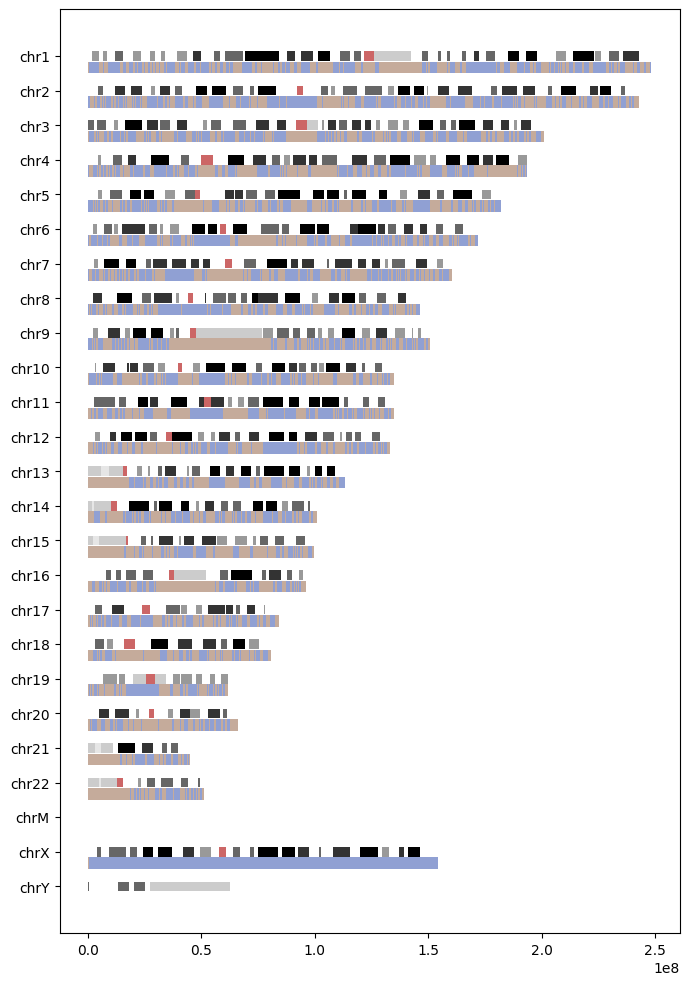

In [149]:
# data = df.loc[df['sample']=='HG00621', ['chrom', 'switch_error_site']].rename(columns={'switch_error_site':'start'}).reset_index(drop=True)
reload(ideograms)
from ideograms import plot_ideogram
# data.reset_index()
plot_phasing_blocks('HG00621', df)

In [129]:

# data_list=list()
# empty_line=pd.DataFrame(['chr1', -1, -1, -1])
# for chrom, df in data.groupby('chrom'):
#     chrom_end = data.loc[data.chrom==chrom, 'end'].max()
#     if df.iat[0, 1] != 0:
#         df = pd.concat((empty_line, df))
#         df.iat[0, 1] = 0
#         df.iat[0, 2] = df.iat[1, 1]
#     if df.iat[0, 2] != chrom_end:
#         df = pd.concat((df, empty_line))
#         df.iat[-1, 1] = df.iat[-2, 2]
#         df.iat[-1, 2] = chrom_end
#     data_list.append(df)